Introduction
--
In our ever changing and evolving field of technology one of the foremost topics is data analytics. The growth in the amount of digital data that is being collected across many different fields is massive and . That is, taking data in whatever raw form it exists and using technology to transform it into information that has value and context. In most cases data analysis is performed in order to provide class descriptions of data, highlight behaviors, trends, associations in the data or predictive information that prove useful or even vital to key decision-makers. 


In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

Data Collection
--
Using the NHL API following the documentation found at https://gitlab.com/dword4/nhlapi/tree/master

For each player in the specified year range (years must be consecutive) collect all avalible stats 

In [ ]:
def get_csv_skaters(y1, y2):
    team_rosters = requests.get('https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season=' + y1 + y2)
    team_rosters = team_rosters.json()
    players= []
    for i in range(0, len(team_rosters['teams'])):
        for j in range(0, len(team_rosters['teams'][i]['roster']['roster'])):
            player = [team_rosters['teams'][i]['roster']['roster'][j]['person']['id'], 
                      team_rosters['teams'][i]['roster']['roster'][j]['person']['fullName'],
                     team_rosters['teams'][i]['name']]
            if (team_rosters['teams'][i]['roster']['roster'][j]['position']['code'] != 'G'):
                players.append(player)
    players_stats = []
    labels = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                           + str(players[i][0]) 
                           + '/stats?stats=statsSingleSeason&season=' + y1 + y2).json()
    labels = labels['stats'][0]['splits'][0]['stat']
    header = ['id', 'fullName', 'teamName']
    for label in labels:
        header.append(label)
    for i in range(0, len(players)): 
        stats = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                           + str(players[i][0]) 
                           + '/stats?stats=statsSingleSeason&season=' + y1 + y2).json()
        if(stats['stats'][0]['splits'] == []):
            players_stats.append([0] * len(labels))
            continue
        stats = stats['stats'][0]['splits'][0]['stat']
        stats_array = []
        for label in labels:
            if label in stats:
                stats_array.append(stats[label])
            else:
                stats_array.append(0)
        players_stats.append(stats_array)
        
    skaters = []
    skaters.append(header)
    for i in range(0, len(players)):
        skaters.append(players[i] + players_stats[i])
    return skaters

Returns the skaters data for a year range and saves the result as a csv file.
Years must be in the range [1917, 2019], note that the 2004-2005 season is skipped as this was a lockout year.

In [ ]:
def get_skaters_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting skaters data for " + str(i) + "-" + str(i+1) + " season.")
        skaters = get_csv_skaters(str(i), str(i+1))
        np.savetxt('data/skaters_' + str(i) + '_' + str(i+1) + '.csv', skaters, fmt='%s', delimiter=',')

In [ ]:
get_skaters_data(1917,1918)

For each team in the specified year range (years must be consecutive) collect all avalible stats 

In [ ]:
def get_csv_team(y1, y2):
    teams = requests.get('https://statsapi.web.nhl.com/api/v1/teams?season=' + str(y1) + str(y2))
    teams = teams.json()
    team_id_name = []
    for i in range(0, len(teams['teams'])):
        team_arr = [teams['teams'][i]['id'], teams['teams'][i]['name']]
        team_id_name.append(team_arr)

    labels = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                           + str(team_id_name[0][0])
                           + '/stats?stats=statsSingleSeason&season=' + str(y1) + str(y2)).json()
    labels = labels['stats'][0]['splits'][0]['stat']
    header = ['id', 'teamName']
    for label in labels:
        header.append(label)

    team_stats = []
    for i in range(0, len(team_id_name)):
        stats = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                             + str(team_id_name[i][0]) 
                             + '/stats?stats=statsSingleSeason&season=' + str(y1) + str(y2)).json()
        if(stats['stats'][0]['splits'] == []):
            team_stats.append([0] * len(labels))
            continue
        stats = stats['stats'][0]['splits'][0]['stat']
        stats_array = []
        for label in labels:
            if label in stats:
                stats_array.append(stats[label])
            else:
                stats_array.append(0)
        team_stats.append(stats_array)

    
    teams_stats_final = []
    teams_stats_final.append(header)
    for i in range(0, len(team_id_name)):
        teams_stats_final.append(team_id_name[i] + team_stats[i]) 
    return teams_stats_final

Gets the team data for a year range and saves the result as a csv file.
Years must be in the range [1917, 2019], note that the 2004-2005 season is skipped as this was a lockout year.

In [ ]:
def get_team_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting team data for " + str(i) + "-" + str(i+1) + " season.")
        data = get_csv_team(str(i), str(i+1))
        np.savetxt('team_data/teams_' + str(i) + '_' + str(i+1) + '.csv', data, fmt='%s', delimiter=',')

In [ ]:
get_team_data(1917, 1918)

Returns the index of the team stats 

In [ ]:
def get_team_stats(id, team_data):
    for i in range(0, len(team_data)):
        if team_data[i][0] == id:
            return i

For each game in the specified year range (years must be consecutive) return the winner, away team ID, home team ID, and the away and home team stats for that season

In [ ]:
def get_csv_game(y1, y2):
    team_data = get_csv_team(y1, y2)
    header = team_data[0][3:]
    away_header = []
    home_header = []
    for head in header:
        away_header.append('away_'+head)
        home_header.append('home_'+head)
    games_data = [['winner', 'awayID', 'homeID'] + away_header + home_header]
    games = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?startDate=' 
                         + str(y1) + '-10-01&endDate=' + str(y2) + '-06-30')
    games = games.json()
    for date in games['dates']:
        for game in date['games']:
            away_ID = game['teams']['away']['team']['id']
            home_ID = game['teams']['home']['team']['id']
            if away_ID > 80 or home_ID > 80:
                continue
            
            away_score = game['teams']['away']['score']
            home_score = game['teams']['home']['score']
            winner = 0
            away_stats = team_data[get_team_stats(away_ID, team_data)][3:]
            home_stats = team_data[get_team_stats(home_ID, team_data)][3:]
            if home_score > away_score:
                winner = 1
            games_data.append([winner,
                          away_ID, 
                          home_ID] +
                          away_stats +
                          home_stats)
    return games_data

Gets the game data for a year range and saves the result as a csv file.
Years must be in the range [1917, 2019], note that the 2004-2005 season is skipped as this was a lockout year.

In [ ]:
def get_game_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting game data for " + str(i) + "-" + str(i+1) + " season.")
        data = get_csv_game(i, i+1)
        np.savetxt('game_data/game_data_' + str(i) + '_' + str(i+1) + '.csv', data, fmt='%s', delimiter=',')

In [ ]:
get_game_data(1917,1918)

Aanaylsis
--

header for each dataset is 
winner, awayID, homeID, wins, losses, ot, pts, ptPctg, goalsPerGame, goalsAgainstPerGame, evGGARatio, powerPlayPercentage, powerPlayGoals, powerPlayGoalsAgainst, powerPlayOpportunities, penaltyKillPercentage, shotsPerGame, shotsAllowed, winScoreFirst, winOppScoreFirst, winLeadFirstPer, winLeadSecondPer, winOutshootOpp, win OutshotByOpp, faceOffstaken, faceOffsWon, faceOffsLost, faceOffWinPercentage, shootingPctg, savePctg

Index(['winner', 'awayID', 'homeID', 'wins', 'losses', 'ot', 'pts', 'ptPctg',
       'goalsPerGame', 'goalsAgainstPerGame', 'evGGARatio',
       'powerPlayPercentage', 'powerPlayGoals', 'powerPlayGoalsAgainst',
       'powerPlayOpportunities', 'penaltyKillPercentage', 'shotsPerGame',
       'shotsAllowed', 'winScoreFirst', 'winOppScoreFirst', 'winLeadFirstPer',
       'winLeadSecondPer', 'winOutshootOpp', 'winOutshotByOpp',
       'faceOffsTaken', 'faceOffsWon', 'faceOffsLost', 'faceOffWinPercentage',
       'shootingPctg', 'savePctg', 'wins.1', 'losses.1', 'ot.1', 'pts.1',
       'ptPctg.1', 'goalsPerGame.1', 'goalsAgainstPerGame.1', 'evGGARatio.1',
       'powerPlayPercentage.1', 'powerPlayGoals.1', 'powerPlayGoalsAgainst.1',
       'powerPlayOpportunities.1', 'penaltyKillPercentage.1', 'shotsPerGame.1',
       'shotsAllowed.1', 'winScoreFirst.1', 'winOppScoreFirst.1',
       'winLeadFirstPer.1', 'winLeadSecondPer.1', 'winOutshootOpp.1',
       'winOutshotByOpp.1', 'faceOffsTaken.1', 'faceOffsWon.1',
       'faceOffsLost.1', 'faceOffWinPercentage.1', 'shootingPctg.1',
       'savePctg.1'],
      dtype='object')

In [2]:
def normalize(data):
    max_data = np.max(data, axis=0)
    min_data = np.min(data, axis=0)
    stats = ['away_wins', 'away_losses', 'away_ot',
             'away_pts', 'away_ptPctg', 'away_goalsPerGame',
             'away_goalsAgainstPerGame', 'away_evGGARatio',
             'away_powerPlayPercentage', 'away_powerPlayGoals',
             'away_powerPlayGoalsAgainst', 'away_powerPlayOpportunities',
             'away_penaltyKillPercentage', 'away_shotsPerGame', 'away_shotsAllowed',
             'away_winScoreFirst', 'away_winOppScoreFirst', 'away_winLeadFirstPer',
             'away_winLeadSecondPer', 'away_winOutshootOpp', 'away_winOutshotByOpp',
             'away_faceOffsTaken', 'away_faceOffsWon', 'away_faceOffsLost',
             'away_faceOffWinPercentage', 'away_shootingPctg', 'away_savePctg',
             'home_wins', 'home_losses', 'home_ot', 'home_pts', 'home_ptPctg',
             'home_goalsPerGame', 'home_goalsAgainstPerGame', 'home_evGGARatio',
             'home_powerPlayPercentage', 'home_powerPlayGoals',
             'home_powerPlayGoalsAgainst', 'home_powerPlayOpportunities',
             'home_penaltyKillPercentage', 'home_shotsPerGame', 'home_shotsAllowed',
             'home_winScoreFirst', 'home_winOppScoreFirst', 'home_winLeadFirstPer',
             'home_winLeadSecondPer', 'home_winOutshootOpp', 'home_winOutshotByOpp',
             'home_faceOffsTaken', 'home_faceOffsWon', 'home_faceOffsLost',
             'home_faceOffWinPercentage', 'home_shootingPctg', 'home_savePctg']
    for stat in stats:
        data[stat] = (data[stat] - min_data[stat])/(max_data[stat] - min_data[stat])
    return data

In [4]:
data_2000_2001 = pd.read_csv('game_data/game_data_2000_2001.csv', header=0)
data_2001_2002 = pd.read_csv('game_data/game_data_2001_2002.csv', header=0)
data_2002_2003 = pd.read_csv('game_data/game_data_2002_2003.csv', header=0)
data_2003_2004 = pd.read_csv('game_data/game_data_2003_2004.csv', header=0)

data_2005_2006 = pd.read_csv('game_data/game_data_2005_2006.csv', header=0)
data_2006_2007 = pd.read_csv('game_data/game_data_2006_2007.csv', header=0)
data_2007_2008 = pd.read_csv('game_data/game_data_2007_2008.csv', header=0)
data_2008_2009 = pd.read_csv('game_data/game_data_2008_2009.csv', header=0)
data_2009_2010 = pd.read_csv('game_data/game_data_2009_2010.csv', header=0)
data_2010_2011 = pd.read_csv('game_data/game_data_2010_2011.csv', header=0)
data_2011_2012 = pd.read_csv('game_data/game_data_2011_2012.csv', header=0)
data_2012_2013 = pd.read_csv('game_data/game_data_2012_2013.csv', header=0)
data_2013_2014 = pd.read_csv('game_data/game_data_2013_2014.csv', header=0)
data_2014_2015 = pd.read_csv('game_data/game_data_2014_2015.csv', header=0)
data_2015_2016 = pd.read_csv('game_data/game_data_2015_2016.csv', header=0)
data_2016_2017 = pd.read_csv('game_data/game_data_2016_2017.csv', header=0)
data_2017_2018 = pd.read_csv('game_data/game_data_2017_2018.csv', header=0)

data_2000_2001 = normalize(data_2000_2001)
data_2001_2002 = normalize(data_2001_2002)
data_2002_2003 = normalize(data_2002_2003)
data_2003_2004 = normalize(data_2003_2004)

data_2005_2006 = normalize(data_2005_2006)
data_2006_2007 = normalize(data_2006_2007)
data_2007_2008 = normalize(data_2007_2008)
data_2008_2009 = normalize(data_2008_2009)
data_2009_2010 = normalize(data_2009_2010)
data_2010_2011 = normalize(data_2010_2011)
data_2011_2012 = normalize(data_2011_2012)
data_2012_2013 = normalize(data_2012_2013)
data_2013_2014 = normalize(data_2013_2014)
data_2014_2015 = normalize(data_2014_2015)
data_2016_2017 = normalize(data_2016_2017)
data_2017_2018 = normalize(data_2017_2018)

frames = [data_2000_2001, data_2001_2002, data_2002_2003, data_2003_2004, data_2005_2006, 
          data_2006_2007, data_2007_2008, data_2008_2009, data_2009_2010, data_2010_2011, 
          data_2011_2012, data_2012_2013, data_2013_2014, data_2014_2015, data_2015_2016, 
          data_2016_2017, data_2017_2018]
data = pd.concat(frames)

In [5]:
data.head()

,winner,awayID,homeID,away_wins,away_losses,away_ot,away_pts,away_ptPctg,away_goalsPerGame,away_goalsAgainstPerGame,...,home_winLeadFirstPer,home_winLeadSecondPer,home_winOutshootOpp,home_winOutshotByOpp,home_faceOffsTaken,home_faceOffsWon,home_faceOffsLost,home_faceOffWinPercentage,home_shootingPctg,home_savePctg
0,0,21,25,1.000000,0.000000,0.375,1.000000,1.000000,0.803099,0.075019,...,0.922902,0.975930,0.974771,0.709957,0.150456,0.315615,0.191977,0.560440,0.942857,0.733333
1,0,9,6,0.870968,0.142857,0.375,0.863636,0.863524,0.834087,0.197989,...,0.768707,0.792123,0.571101,0.357143,0.524316,0.352159,0.512894,0.340659,0.400000,0.000000
2,1,16,7,0.258065,0.685714,0.500,0.287879,0.287841,0.330536,0.584687,...,1.000000,0.978118,0.940367,0.601732,0.384498,0.343854,0.388252,0.428571,0.485714,1.000000
3,1,23,4,0.483871,0.342857,0.750,0.575758,0.575682,0.559070,0.508894,...,0.557823,0.691466,0.566514,0.857143,0.594225,0.486711,0.462751,0.461538,0.457143,0.566667
4,0,17,20,0.903226,0.114286,0.375,0.893939,0.893300,0.668819,0.169374,...,0.557823,0.509847,0.458716,0.073593,0.574468,0.588040,0.356734,0.604396,0.171429,0.266667


In [6]:
def prepare(data):
    X = data.iloc[:,3:].values

    # we normalize X
#     maxX = np.max(X, axis=0)
#     minX = np.min(X, axis=0)
#     X = (X-minX)/(maxX-minX)

    # we insert an all-ones column at index 0
    X = np.insert(X, 0, 1, axis=1)
    
    # get the first column of the data
    y = data.iloc[:,0:1].values
    
    # we normalize y
#     maxy = np.max(y, axis=0)
#     miny = np.min(y, axis=0)
#     y = (y-miny)/(maxy-miny)

    where_are_zeros = (y==0)
    y[where_are_zeros] = -1
    return X,y

In [7]:
X,y = prepare(data)

print(X.shape)
print(y.shape)
print(X,y)

(22122, 55)
(22122, 1)
[[ 1.          1.          0.         ...,  0.56043956  0.94285714
   0.73333333]
 [ 1.          0.87096774  0.14285714 ...,  0.34065934  0.4         0.        ]
 [ 1.          0.25806452  0.68571429 ...,  0.42857143  0.48571429  1.        ]
 ..., 
 [ 1.          0.89655172  0.22222222 ...,  0.62626263  1.          0.53333333]
 [ 1.          0.89655172  0.22222222 ...,  0.62626263  1.          0.53333333]
 [ 1.          0.82758621  0.2962963  ...,  0.47474747  0.74193548  0.6       ]] [[-1]
 [-1]
 [ 1]
 ..., 
 [ 1]
 [ 1]
 [-1]]


In [8]:
#TODO
def error(x,y,w):
    #print(-y*x@w.T)
    return np.log(1+np.exp(-y*x@w.T))

#TODO
def error_mean(X,y,w):
    return sum(error(X,y,w))/len(y)

In [9]:
#TODO
def grad(x,y,w):
    #print(y*x@w.T)
    return (y*x)/(1+np.exp(y*x@w.T))

#TODO
def grad_mean(X,y,w):
    return -1/len(y)*sum(grad(X,y,w))

In [10]:
def fit(X,y,kappa,iter):
    w = np.zeros((1,X.shape[1]))
    E = []

    #TODO
    for i in range(0,iter):
        E.append(error_mean(X,y,w))
        w = w - kappa*grad_mean(X,y,w)
    return w,E

[[  3.43620995e-06  -2.99744695e-06   5.91523929e-06   2.80639671e-06
   -5.31380303e-06  -3.27616875e-06   7.53547118e-08   3.11775940e-06
   -9.76453651e-08  -3.55971221e-09  -8.72447761e-07   4.43923865e-06
    2.98254381e-06   3.47191796e-07   2.30110087e-07   2.94262359e-06
    3.90446640e-07   1.41930371e-08   8.45607593e-07   1.01755158e-06
    1.71409812e-07  -3.41067690e-09   1.49699132e-05   6.57870855e-06
    1.02075709e-05   1.29237500e-06   5.13134783e-07   7.57858135e-07
    7.25753000e-06  -3.25307326e-06   6.08331209e-07   1.01164202e-05
    7.75809508e-06   3.20676643e-06  -1.51649139e-07   3.25956664e-06
    3.24547885e-06   4.05277480e-06  -2.17199144e-07   2.32389904e-06
    3.44437122e-06   2.76363378e-06   3.32218242e-07   3.73331838e-06
    3.33894766e-06   3.59790454e-06   3.37172120e-06   3.85526593e-06
    3.61295366e-06  -4.89926610e-08   9.42409866e-06  -7.91571645e-06
    2.49724569e-06   3.21045409e-06   2.98821113e-06]]


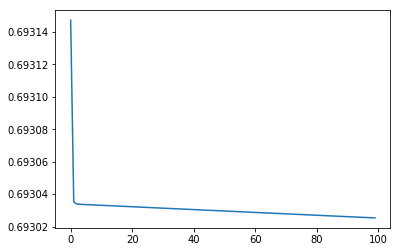

In [11]:
w,E = fit(X,y,0.000001,100)
print(w)
plt.plot(E)
plt.show()

In [12]:
def predict(w, X):
    pred = 1/(1+np.exp(X@-w.T))
    for n in range(0, len(pred)):
        if(pred[n] < 0.5):
            pred[n] = -1
        else:
            pred[n] = 1
    return pred
#TODO
def accuracy(y,y_pred):
    acc = 0
    for n in range(0,len(y)):
        if(y[n] + y_pred[n] == 0):
            acc = acc +1
    return 1-((acc)/len(y))

y_pred = predict(w,X)
#print(y_pred)
print( accuracy(y,y_pred) )

0.5362082994304312


In [13]:
def split_train_test(X,y,pct=80):
    n = X.shape[0]
    s = round(n * pct / 100)
    
    indices = np.random.permutation(n)
    train_idx, test_idx = indices[:s], indices[s:]
    
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]
    
    return X_train, y_train, X_test, y_test

[[  1.08325453e-05  -8.88955529e-06   1.78910091e-05   8.40346325e-06
   -1.62501792e-05  -9.89541606e-06   5.46296989e-07   9.70971773e-06
   -9.28664803e-08   4.22752910e-07  -2.05697264e-06   1.36739573e-05
    6.24689235e-06   6.37578619e-07   6.95196134e-07   8.93221332e-06
    1.45324629e-06   2.51477008e-07   2.86349962e-06   3.40186436e-06
    7.88880646e-07   2.29459168e-07   5.42622416e-06  -4.87089378e-07
    1.16828520e-05   3.80841435e-06   1.86262818e-06   2.49323726e-06
    2.33279504e-05  -1.12822588e-05   2.16130657e-06   3.32305942e-05
    2.51110591e-05   9.89904583e-06  -1.82532787e-07   9.88554025e-06
    1.02341673e-05   1.30878335e-05   7.35069682e-07   6.79732738e-06
    9.91368923e-06   8.32979791e-06   1.00760160e-06   1.13824448e-05
    1.01802928e-05   1.10246671e-05   1.02750147e-05   1.17727426e-05
    1.10120940e-05   4.68778901e-06   2.64818742e-05  -1.68727296e-05
    7.49140747e-06   1.00590772e-05   9.23912993e-06]]


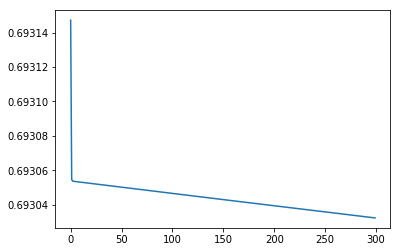

0.5298372513562387


In [14]:
X_train, y_train, X_test, y_test = split_train_test(X,y,pct=80)
w,E = fit(X_train,y_train,0.000001,300)
print(w)
plt.plot(E)
plt.show()
y_pred = predict(w,X_test)
print( accuracy(y_test,y_pred) )

In [15]:
predictions = []
predictions.append(y_pred)

In [16]:
predictions

[array([[ 1.],
        [ 1.],
        [ 1.],
        ..., 
        [ 1.],
        [ 1.],
        [ 1.]])]

Logistic regression binary classifier in Tensorflow
--

In [17]:
import tensorflow as tf

In [18]:
def accuracy(A, Y):
    P = A>.5      #prediction
    num_agreements = np.sum(P==Y)
    return num_agreements / Y.shape[0]

In [19]:
def prepare_tensorFlow(data):
    X = data.iloc[:,3:].values
    # we insert an all-ones column at index 0
    X = np.insert(X, 0, 1, axis=1)
    # get the first column of the data
    y = data.iloc[:,0:1].values
    return X,y

In [20]:
data_2000_2001 = pd.read_csv('game_data/game_data_2000_2001.csv', header=0)
data_2001_2002 = pd.read_csv('game_data/game_data_2001_2002.csv', header=0)
data_2002_2003 = pd.read_csv('game_data/game_data_2002_2003.csv', header=0)
data_2003_2004 = pd.read_csv('game_data/game_data_2003_2004.csv', header=0)
data_2005_2006 = pd.read_csv('game_data/game_data_2005_2006.csv', header=0)
data_2006_2007 = pd.read_csv('game_data/game_data_2006_2007.csv', header=0)
data_2007_2008 = pd.read_csv('game_data/game_data_2007_2008.csv', header=0)
data_2008_2009 = pd.read_csv('game_data/game_data_2008_2009.csv', header=0)
data_2009_2010 = pd.read_csv('game_data/game_data_2009_2010.csv', header=0)
data_2010_2011 = pd.read_csv('game_data/game_data_2010_2011.csv', header=0)
data_2011_2012 = pd.read_csv('game_data/game_data_2011_2012.csv', header=0)
data_2012_2013 = pd.read_csv('game_data/game_data_2012_2013.csv', header=0)
data_2013_2014 = pd.read_csv('game_data/game_data_2013_2014.csv', header=0)
data_2014_2015 = pd.read_csv('game_data/game_data_2014_2015.csv', header=0)
data_2015_2016 = pd.read_csv('game_data/game_data_2015_2016.csv', header=0)
data_2016_2017 = pd.read_csv('game_data/game_data_2016_2017.csv', header=0)
data_2017_2018 = pd.read_csv('game_data/game_data_2017_2018.csv', header=0)

#each one of these data sets needs to be normalized 
data_2000_2001 = normalize(data_2000_2001)
# #np.savetxt('test.csv', data_2000_2001, fmt='%s', delimiter=',')
data_2001_2002 = normalize(data_2001_2002)
data_2002_2003 = normalize(data_2002_2003)
data_2003_2004 = normalize(data_2003_2004)
data_2005_2006 = normalize(data_2005_2006)
data_2006_2007 = normalize(data_2006_2007)
data_2007_2008 = normalize(data_2007_2008)
data_2008_2009 = normalize(data_2008_2009)
data_2009_2010 = normalize(data_2009_2010)
data_2010_2011 = normalize(data_2010_2011)
data_2011_2012 = normalize(data_2011_2012)
data_2012_2013 = normalize(data_2012_2013)
data_2013_2014 = normalize(data_2013_2014)
data_2014_2015 = normalize(data_2014_2015)
data_2016_2017 = normalize(data_2016_2017)
data_2017_2018 = normalize(data_2017_2018)


frames = [data_2000_2001, data_2001_2002, data_2002_2003, data_2003_2004, data_2005_2006, 
          data_2006_2007, data_2007_2008, data_2008_2009, data_2009_2010, data_2010_2011, 
          data_2011_2012, data_2012_2013, data_2013_2014, data_2014_2015, data_2015_2016, 
          data_2016_2017, data_2017_2018]
data = pd.concat(frames)

X,y = prepare_tensorFlow(data)

X,Y,X_test,Y_test = split_train_test(X,y,pct=80)


In [21]:
# We will reshape the Y arrays so that they are not rank 1 arrays but rank 2 arrays. 
# They should be rank 2 arrays.

Y = Y.reshape((Y.shape[0],1))
Y_test = Y_test.reshape((Y_test.shape[0],1))

print("Train dataset shape", X.shape, Y.shape)
print("Test dataset shape", X_test.shape, Y_test.shape)

print("Y =", Y)

m   = X.shape[0] 
n_x = X.shape[1]

Train dataset shape (17698, 55) (17698, 1)
Test dataset shape (4424, 55) (4424, 1)
Y = [[0]
 [0]
 [0]
 ..., 
 [1]
 [1]
 [1]]


In [22]:
# Input data.
# Load the training and test data into constants
tf_X = tf.constant(X.astype(np.float32))
tf_Y = tf.constant(Y.astype(np.float32))
tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
# These are the parameters that we are going to be training.
tf_w = tf.Variable(tf.zeros((n_x, 1)))
tf_b = tf.Variable(tf.zeros((1,1)))

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the sigmoid and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
tf_Z = tf.matmul(tf_X, tf_w) + tf_b
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) )

# Optimizer.
# We are going to find the minimum of this loss using gradient descent.
# We pass alpha=0.1 as input parameter.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the train and test data.
# These are not part of training, but merely here so that we can report
# accuracy figures as we train.
tf_A = tf.nn.sigmoid(tf_Z)
tf_A_test = tf.nn.sigmoid(tf.matmul(tf_X_test, tf_w) + tf_b)

In [23]:
session = tf.InteractiveSession()

# This is a one-time operation which ensures the parameters get initialized as
# we described in the graph: random weights for the matrix, zeros for the biases. 
tf.global_variables_initializer().run()
print("Initialized")

for iter in range(1000):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the cost value and the training predictions returned as numpy arrays.
    _, J, A = session.run([optimizer, tf_J, tf_A])
    
    print(iter, J)

Initialized
0 0.693131
1 449.845
2 6335.58
3 1351.7
4 5300.16
5 2251.25
6 4264.79
7 3150.75
8 3229.43
9 4050.26
10 2194.06
11 4949.74
12 1158.71
13 5848.98
14 124.151
15 6736.46
16 779.91
17 5957.29
18 1680.18
19 4921.9
20 2579.71
21 3886.54
22 3479.21
23 2851.17
24 4378.72
25 1815.8
26 5278.2
27 780.487
28 6176.93
29 220.693
30 6592.45
31 1128.21
32 5556.94
33 2027.84
34 4521.57
35 2927.34
36 3486.2
37 3826.85
38 2450.83
39 4726.35
40 1415.48
41 5625.71
42 380.495
43 6519.53
44 563.025
45 6205.46
46 1464.25
47 5170.05
48 2363.8
49 4134.68
50 3263.31
51 3099.31
52 4162.8
53 2063.95
54 5062.29
55 1028.62
56 5961.26
57 5.81742
58 4985.04
59 2524.47
60 3949.67
61 3423.97
62 2914.3
63 4323.48
64 1878.94
65 5222.92
66 843.712
67 6120.65
68 164.364
69 6658.65
70 1070.31
71 5623.15
72 1969.93
73 4587.78
74 2869.44
75 3552.41
76 3768.94
77 2517.04
78 4668.42
79 1481.71
80 5567.61
81 447.104
82 6458.66
83 502.166
84 6274.84
85 1403.61
86 5239.4
87 2303.16
88 4204.04
89 3202.67
90 3168.67
91 410

742 812.191
743 6136.05
744 182.469
745 6625.79
746 1094.24
747 5582.63
748 1999.69
749 4544.18
750 2901.36
751 3508.14
752 3800.73
753 2473.87
754 4697.63
755 1442.44
756 5590.58
757 416.055
758 6477.71
759 523.367
760 6235.7
761 1432.69
762 5194.49
763 2336.6
764 4157.01
765 3237.42
766 3121.56
767 4135.97
768 2088.17
769 5031.64
770 1058.32
771 5922.64
772 47.8886
773 3469.73
774 2854.27
775 4368.13
776 1821.06
777 5263.51
778 791.584
779 6154.05
780 200.722
781 6604.28
782 1112.88
783 5560.57
784 2018.74
785 4521.76
786 2920.68
787 3485.54
788 3820.18
789 2451.22
790 4717.14
791 1419.75
792 5610.21
793 393.22
794 6497.63
795 543.465
796 6212.09
797 1453.11
798 5170.48
799 2357.31
800 4132.77
801 3258.29
802 3097.24
803 4156.89
804 2063.86
805 5052.56
806 1034.03
807 5943.64
808 39.3889
809 1514.92
810 5099.4
811 2419.1
812 4061.67
813 3320.08
814 3026.15
815 4218.66
816 1992.81
817 5114.26
818 963.06
819 6005.27
820 56.1423
821 5070.08
822 2444.52
823 4032.43
824 3345.41
825 2996.9

In [25]:
# Calling .eval() is basically like calling run(), but
# just to get that one numpy array. 
# Note that it recomputes all its computation graph dependencies.
A = tf_A.eval()
A_test = tf_A_test.eval()

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))

Accuracy on the train set is  0.564244547406
Accuracy on the test set is  0.575045207957


array([[ True],
       [False],
       [ True],
       ..., 
       [False],
       [ True],
       [ True]], dtype=bool)

In [26]:
pred = []
for i in range(0, len(A)):
    if(A[i] < 0.5):
        pred.append(0)
    else:
        pred.append(1)

In [28]:
predictions.append(pred)

In [29]:
predictions

[array([[ 1.],
        [ 1.],
        [ 1.],
        ..., 
        [ 1.],
        [ 1.],
        [ 1.]]),
 [1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

Stochastic Gradient Descent
--

In [30]:
# Input data.
# Let's use placeholders for the training data. 
# This is so that we can suply batches of tranining examples each iteration.
tf_X = tf.placeholder(tf.float32)
tf_Y = tf.placeholder(tf.float32)

tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
# These are the parameters that we are going to be training.
tf_w = tf.Variable( tf.zeros((n_x, 1)) )
tf_b = tf.Variable(tf.zeros((1,1)))

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the sigmoid and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
tf_Z = tf.matmul(tf_X, tf_w) + tf_b
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) )

# Optimizer.
# We are going to find the minimum of this loss using gradient descent.
# We pass alpha=0.1 as input parameter.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the train and test data.
# These are not part of training, but merely here so that we can report
# accuracy figures as we train.
tf_A = tf.nn.sigmoid(tf_Z)
tf_A_test = tf.nn.sigmoid(tf.matmul(tf_X_test, tf_w) + tf_b)

In [31]:
num_steps = 10001
batch_size = 100

tf.global_variables_initializer().run()
print("Initialized")

for step in range(num_steps):
    # Pick an offset within the training data.
    offset = (step * batch_size) % (X.shape[0] - batch_size)
    
    # Generate a minibatch.
    X_batch = X[offset:(offset + batch_size), :]
    Y_batch = Y[offset:(offset + batch_size), :]
    
    _, J, A = session.run([optimizer, tf_J, tf_A], feed_dict={tf_X : X_batch, tf_Y : Y_batch})
    
    if (step % 500 == 0):
        print("Minibatch loss at step ", (step, J))
        print("Minibatch accuracy: ", accuracy(A, Y_batch))
        A_test = tf_A_test.eval()
        print("Test accuracy: ", accuracy(A_test,Y_test))

Initialized
Minibatch loss at step  (0, 0.69314742)
Minibatch accuracy:  0.51
Test accuracy:  0.524638336347
Minibatch loss at step  (500, 6175.9438)
Minibatch accuracy:  0.42
Test accuracy:  0.475813743219
Minibatch loss at step  (1000, 438.9259)
Minibatch accuracy:  0.61
Test accuracy:  0.476265822785
Minibatch loss at step  (1500, 4737.6914)
Minibatch accuracy:  0.47
Test accuracy:  0.586347197107
Minibatch loss at step  (2000, 13.501985)
Minibatch accuracy:  0.43
Test accuracy:  0.50452079566
Minibatch loss at step  (2500, 16026.245)
Minibatch accuracy:  0.53
Test accuracy:  0.512432188065
Minibatch loss at step  (3000, 9815.2871)
Minibatch accuracy:  0.62
Test accuracy:  0.486211573237
Minibatch loss at step  (3500, 7622.7773)
Minibatch accuracy:  0.58
Test accuracy:  0.518309222423
Minibatch loss at step  (4000, 755.77429)
Minibatch accuracy:  0.6
Test accuracy:  0.570976491863
Minibatch loss at step  (4500, 8056.3623)
Minibatch accuracy:  0.52
Test accuracy:  0.598101265823
Mini

Neural network in TensorFlow
--

In [32]:
# Input data.

num_hidden_nodes = 15

C = 1

# Load the training and test data into constants
tf_X = tf.constant(X.astype(np.float32))
tf_Y = tf.constant(Y.astype(np.float32))
tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
# These are the parameters that we are going to be training.
tf_w1 = tf.Variable(tf.truncated_normal((n_x, num_hidden_nodes)))
tf_b1 = tf.Variable(tf.zeros((1, num_hidden_nodes)))
tf_w2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, C]))
tf_b2 = tf.Variable(tf.zeros((1, C)))



tf_Z1 = tf.matmul(tf_X, tf_w1) + tf_b1
tf_A1 = tf.nn.relu(tf_Z1)    #tf.nn.relu(tf_Z1)
tf_Z2 = tf.matmul(tf_A1, tf_w2) + tf_b2
tf_A2 = tf.nn.relu(tf_Z2)

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the sigmoid and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z2) )

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tf_J)

# Predictions for the test data.
tf_Z1_test = tf.matmul(tf_X_test, tf_w1) + tf_b1
tf_A1_test = tf.nn.relu(tf_Z1_test)
tf_Z2_test = tf.matmul(tf_A1_test, tf_w2) + tf_b2
tf_A2_test = tf.nn.relu(tf_Z2_test)

In [33]:
session = tf.InteractiveSession()

# This is a one-time operation which ensures the parameters get initialized as
# we described in the graph: random weights for the matrix, zeros for the biases. 
tf.global_variables_initializer().run()
print("Initialized")


# Replace None with your code.

for iter in range(300):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the cost value and the training predictions returned as numpy arrays.
    # Print out the iteration number and cost every 50 iterations.
    _, J, A = session.run([optimizer, tf_J, tf_A2])
    
    if iter%50 ==0:
        print(iter, J)

Initialized
0 79.6169
50 0.679001
100 0.676395
150 0.674188
200 0.672583
250 0.671542


In [34]:
# Print out the accuracy for the training set and test set.
A = tf_A2.eval()
A_test = tf_A2_test.eval()

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))
# Put your code here.

# Call .eval() on tf_A2 and tf_A2_test.

Accuracy on the train set is  0.534297660753
Accuracy on the test set is  0.552667269439


In [35]:
pred = []
for i in range(0, len(A)):
    if(A[i] < 0.5):
        pred.append(0)
    else:
        pred.append(1)

In [36]:
predictions.append(pred)

In [37]:
predictions

[array([[ 1.],
        [ 1.],
        [ 1.],
        ..., 
        [ 1.],
        [ 1.],
        [ 1.]]),
 [1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

Ensamble
--

In [38]:
len(predictions)

3

In [42]:
ensamble_pred = []
for i in range(0, len(predictions[0])):
    sum = predictions[0][i] + predictions[1][i] + predictions[2][i]  
    sum = sum/3
    if(sum < 0.5):
        ensamble_pred.append(0)
    else:
        ensamble_pred.append(1)

In [53]:
print(ensamble_pred)
print(len(Y_test))

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [54]:
count = 0
for i in range(0, len(ensamble_pred)):
    test = Y_test
    if(ensamble_pred[i] == Y_test[i]):
        count += 1
accuracy = count/len(ensamble_pred)
print(accuracy)

0.5027124773960217


Now try with more layers and more hidden nodes
--

In [ ]:
# Input data.

num_hidden_nodes = 100

C = 1

# Load the training and test data into constants
tf_X = tf.constant(X.astype(np.float32))
tf_Y = tf.constant(Y.astype(np.float32))
tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
# These are the parameters that we are going to be training.
tf_w1 = tf.Variable(tf.truncated_normal((n_x, num_hidden_nodes)))
tf_b1 = tf.Variable(tf.zeros((1, num_hidden_nodes)))
tf_w2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes]))
tf_b2 = tf.Variable(tf.zeros((1, C)))
tf_w3 = tf.Variable(tf.truncated_normal([num_hidden_nodes, C]))
tf_b3 = tf.Variable(tf.zeros((1, C)))



tf_Z1 = tf.matmul(tf_X, tf_w1) + tf_b1
tf_A1 = tf.nn.relu(tf_Z1)    #tf.nn.relu(tf_Z1)
tf_Z2 = tf.matmul(tf_A1, tf_w2) + tf_b2
tf_A2 = tf.nn.relu(tf_Z2)
tf_Z3 = tf.matmul(tf_A2, tf_w3) + tf_b3
tf_A3 = tf.nn.relu(tf_Z3)

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the sigmoid and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z3) )

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tf_J)

# Predictions for the test data.
tf_Z1_test = tf.matmul(tf_X_test, tf_w1) + tf_b1
tf_A1_test = tf.nn.relu(tf_Z1_test)
tf_Z2_test = tf.matmul(tf_A1_test, tf_w2) + tf_b2
tf_A2_test = tf.nn.relu(tf_Z2_test)
tf_Z3_test = tf.matmul(tf_A2_test, tf_w3) + tf_b3
tf_A3_test = tf.nn.relu(tf_Z3_test)

In [ ]:
session = tf.InteractiveSession()

# This is a one-time operation which ensures the parameters get initialized as
# we described in the graph: random weights for the matrix, zeros for the biases. 
tf.global_variables_initializer().run()
print("Initialized")


# Replace None with your code.

for iter in range(500):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the cost value and the training predictions returned as numpy arrays.
    # Print out the iteration number and cost every 50 iterations.
    _, J, A = session.run([optimizer, tf_J, tf_A2])
    
    if iter%50 ==0:
        print(iter, J)

In [ ]:
# Print out the accuracy for the training set and test set.
A = tf_A3.eval()
A_test = tf_A3_test.eval()

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))
# Put your code here.

# Call .eval() on tf_A2 and tf_A2_test.